In [111]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matploblib inline

UsageError: Line magic function `%matploblib` not found.


# Physical community resources

Included in this data are physical structures like parks & rec, libraries, community centers, schools, etc. that are funded in part or completely by the city of Philadelphia.

In [94]:
# read in data
housing_counsel = gpd.read_file('../data/adult_resources/HousingCounselingAgencies.geojson')
hospitals = gpd.read_file('../data/city_buildings/Hospitals.geojson')
flu_clinics = gpd.read_file('../data/community_centers/Flu_shot.geojson')
HIV_clinics = gpd.read_file('../data/community_centers/RW_HIV_Treatment_Centers.geojson')
Healthy_Start = gpd.read_file('../data/community_centers/Healthy_Start_CRCs.geojson')
PPR_structures = gpd.read_file('../data/community_centers/PPR_Buildings_Structures.geojson')
schools = gpd.read_file('../data/schools/Schools.geojson')

In [95]:
# add to resource list with common cols

List = []

housing_counsel['Resource'] = "Housing Counseling"
List.append(housing_counsel[['Resource','geometry']])

hospitals['Resource'] = "Hospital"
List.append(hospitals[['Resource','geometry']])

flu_clinics['Resource'] = 'Flu Clinic'
List.append(flu_clinics[['Resource','geometry']])

HIV_clinics['Resource'] = "HIV Clinic"
HIV_clinics = HIV_clinics.groupby('ADDRESS').first()
List.append(HIV_clinics[['Resource','geometry']])

Healthy_Start['Resource'] = "Healthy Start"
List.append(Healthy_Start[['Resource','geometry']])

PPR_structures['Resource'] = "Park and Rec Structure"
PPR_structures = PPR_structures.groupby('ALIAS_ADDRESS').first()
PPR_structures['geometry'] = PPR_structures['geometry'].centroid
List.append(PPR_structures[['Resource','geometry']])

schools['Resource'] = "School"
schools = schools.groupby('STREET_ADDRESS').first()
schools = schools.loc[schools.TYPE_SPECIFIC == "DISTRICT"]
List.append(schools[['Resource','geometry']])


In [96]:
# merge data
structures = pd.concat(List).reset_index()

### Plotting

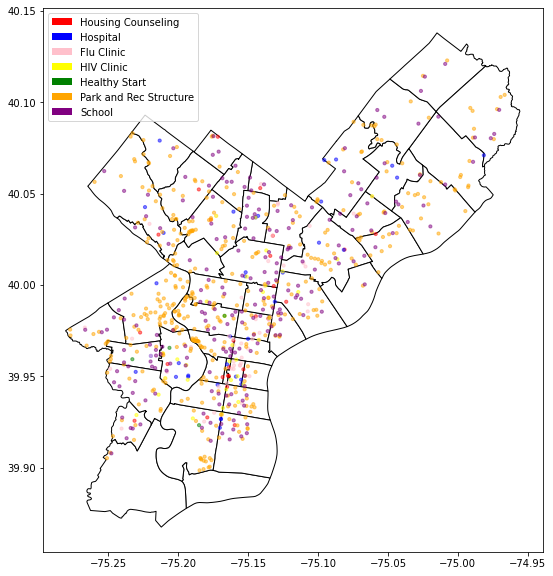

In [74]:
import matplotlib.patches as mpatches

PhillyMap = gpd.read_file('../data/base_geodata/Zipcodes_Poly.geojson')

color_map = {"Housing Counseling":"red","Hospital":"blue","Flu Clinic":"pink",
            "HIV Clinic":"yellow","Healthy Start":"green","Park and Rec Structure":"orange","School":"purple"}

base = PhillyMap.plot(color='white', edgecolor='black', figsize=(10,10))

structures.plot(ax=base,
                markersize=10,
                color=structures.Resource.map(color_map),
                alpha=0.5,
                legend=True)

color_patches = []

for i,j in color_map.items():
    color_patches.append(mpatches.Patch(facecolor=j,label=i))
    
plt.legend(handles=color_patches)

In [81]:
sjoined = gpd.sjoin(structures,PhillyMap,op='within')
PhillyMap['structure_count'] = sjoined.groupby('OBJECTID').size()
PhillyMap['structure_count'] = PhillyMap['structure_count'].fillna(0)

Text(0.5, 1.0, 'Physical Community Structures In Philly Zip Code')

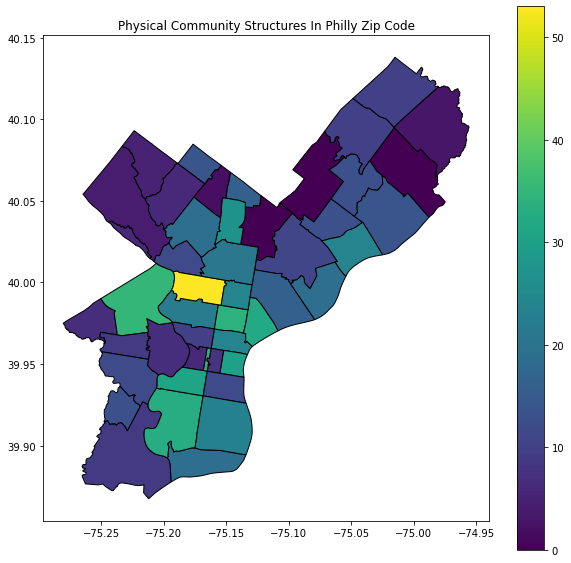

In [93]:
PhillyMap.plot(column="structure_count",edgecolor='black',figsize=(10,10),legend=True)
plt.title("Physical Community Structures In Philly Zip Code")

### Read in Crime Data for 2019

In [97]:
crime_df = pd.read_csv('../data/crime_data/crime_data_2019.csv')

### Definitions
In the FBI’s Uniform Crime Reporting (UCR) Program, violent crime is composed of four offenses: murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force.



In [120]:
violent_codes = [100,200,300,400]
violent_df = crime_df.loc[crime_df.ucr_general.isin(violent_codes)]

violent_df = violent_df.loc[crime_df.lng > -80]
violent_df['geometry'] = gpd.points_from_xy(violent_df['point_x'],violent_df['point_y'])
violent_df_gpd = gpd.GeoDataFrame(violent_df)

<AxesSubplot:>

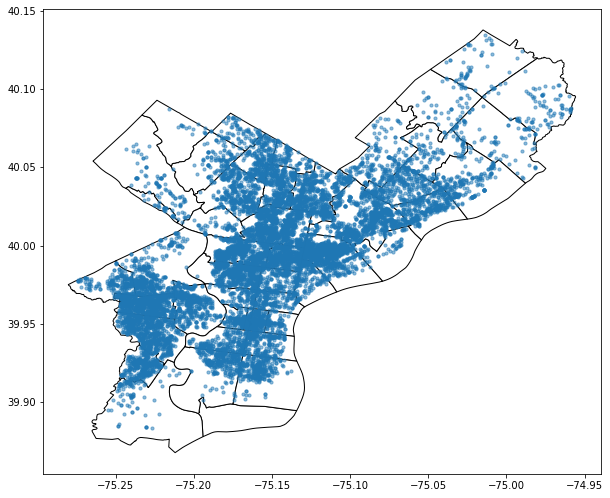

In [123]:
base = PhillyMap.plot(color='white', edgecolor='black', figsize=(10,10))

violent_df_gpd.plot(ax=base,
                markersize=10,
                alpha=0.5,
                legend=True)

In [128]:
sjoined_violent = gpd.sjoin(violent_df_gpd,PhillyMap,op='within')
PhillyMap['violent_crime'] = sjoined_violent.groupby('OBJECTID').size()
PhillyMap['violent_crime'] = PhillyMap['violent_crime'].fillna(0)

/Users/jake/anaconda/envs/Amistad_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Violent Crime In Philly Zip Code')

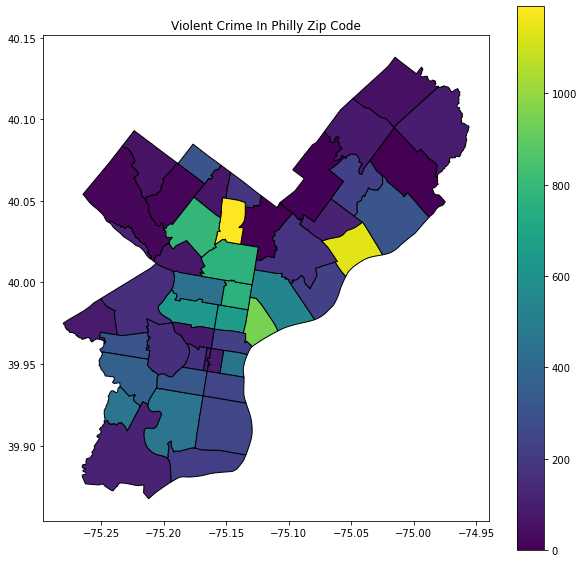

In [129]:
PhillyMap.plot(column="violent_crime",edgecolor='black',figsize=(10,10),legend=True)
plt.title("Violent Crime In Philly Zip Code")

## Plot relationship

<AxesSubplot:xlabel='structure_count', ylabel='violent_crime'>

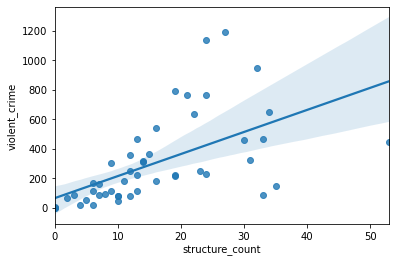

In [134]:
import seaborn as sns
sns.regplot(x="structure_count",y='violent_crime',data=PhillyMap)